# Importing the libraries

In [22]:
import os
import pandas as pd
import numpy as np
import json
import spotipy
import spotipy.oauth2 as oauth2
from spotipy.oauth2 import SpotifyOAuth,SpotifyClientCredentials
import yaml
import re
from tqdm import tqdm
import multiprocessing as mp
import time
import random
import datetime
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
#from skimage import io
from sklearn.preprocessing import OneHotEncoder

# Importing the dataset

In [23]:
df=pd.read_csv('../Data/Spotify_with_genre.csv')

In [24]:
df1=pd.read_csv('../Data/Spotify_with_genre.csv')

In [25]:
df1.columns

Index(['artist_name', 'track_name', 'artist_pop', 'popularity', 'release_date',
       'genre'],
      dtype='object')

In [26]:
df.shape

(5024, 6)

In [27]:
df.drop_duplicates(inplace=True)
df.shape

(5024, 6)

In [28]:
df.columns

Index(['artist_name', 'track_name', 'artist_pop', 'popularity', 'release_date',
       'genre'],
      dtype='object')

In [29]:
#df = df.sample(frac=0.1, random_state=42)  # Adjust fraction size as needed

# Display the shape of the sampled dataset
print(df.shape)

(5024, 6)


In [30]:
#df.shape

In [31]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score
import numpy as np
import pandas as pd

# Assume 'df' is your DataFrame containing the data

# Preprocessing: Convert 'release_date' to 'year' and drop missing values
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df['year'] = df['release_date'].dt.year
df.dropna(subset=['year'], inplace=True)
df.drop(columns=['release_date'], inplace=True)

# One-hot encode categorical columns: 'artist_name' and 'genre'
encoder = OneHotEncoder(sparse=False)
artist_encoded = encoder.fit_transform(df[['artist_name']])
genre_encoded = encoder.fit_transform(df[['genre']])

# Extract numerical features
numerical_features = ['popularity', 'artist_pop', 'year']
numerical_data = df[numerical_features].values

# Normalize numerical features using StandardScaler
scaler = StandardScaler()
numerical_data_scaled = scaler.fit_transform(numerical_data)

# Concatenate all features
X = np.concatenate([numerical_data_scaled, artist_encoded, genre_encoded], axis=1)

# Define the parameter grid for KMeans
param_grid = {
    'n_clusters': [3, 8, 10, 12, 15],  # Values to explore for the number of clusters
    'init': ['k-means++', 'random'],  # Different initialization strategies
    'max_iter': [300, 500, 800]  # Maximum number of iterations for convergence
}

# Initialize KMeans model
kmeans = KMeans(random_state=42)

# Create GridSearchCV
grid_search = GridSearchCV(estimator=kmeans, param_grid=param_grid, cv=5, scoring='adjusted_rand_score')

# Fit the GridSearchCV to the data
grid_search.fit(X)

# Get the best parameters and best silhouette score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Adjusted Rand Score:", best_score)

# Initialize KMeans with the best parameters
best_kmeans = KMeans(n_clusters=best_params['n_clusters'], 
                     init=best_params['init'], 
                     max_iter=best_params['max_iter'], 
                     random_state=42)

# Fit KMeans to the normalized data
best_kmeans.fit(X)

# Evaluate silhouette score
silhouette_avg = silhouette_score(X, best_kmeans.labels_)
print("Silhouette Score:", silhouette_avg)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/si

Best Parameters: {'init': 'k-means++', 'max_iter': 300, 'n_clusters': 3}
Best Adjusted Rand Score: nan


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score: 0.2008082839857169


In [47]:

# Assign clusters to the data using the best model
df['cluster'] = best_kmeans.labels_


In [48]:
import random
import warnings 
import pickle
warnings.simplefilter("ignore")

df.head()

,artist_name,track_name,artist_pop,popularity,genre,year,cluster
0,A Thousand Horses,Preachin' To The Choir,37.0,0.0,Rap,2017.0,0
2,Chambao,Sera,44.0,31.0,Rap,2007.0,4
3,Jeezy,Big Shit Poppin,69.0,19.0,Rap,2007.0,1
5,Julión Álvarez y su Norteño Banda,Ni Lo Intentes,78.0,0.0,Pop,2010.0,1
6,Corey Smith,If I Could Do It Again,40.0,0.0,Pop,2011.0,0


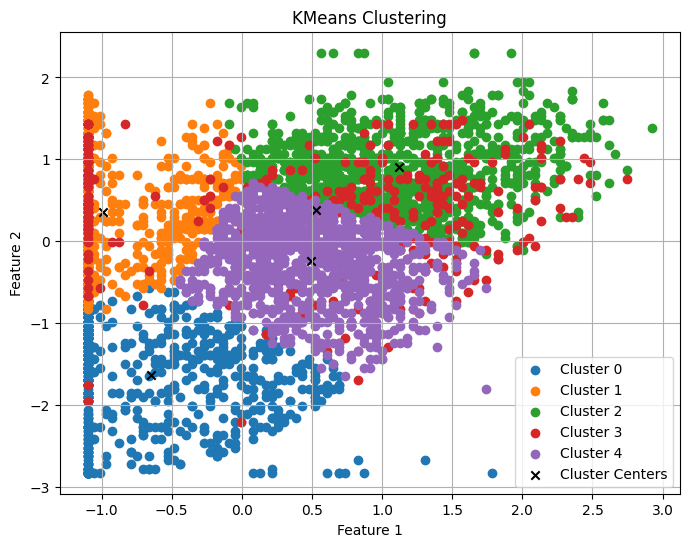

In [49]:
import matplotlib.pyplot as plt

cluster_labels = best_kmeans.labels_
cluster_centers = best_kmeans.cluster_centers_

# Plotting the clusters
plt.figure(figsize=(8, 6))

for cluster_label in set(cluster_labels):
    # Plot data points that belong to this cluster
    plt.scatter(X[cluster_labels == cluster_label, 0], X[cluster_labels == cluster_label, 1], label=f'Cluster {cluster_label}')

# Plotting the cluster centers
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='x', color='black', label='Cluster Centers')

plt.title('KMeans Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()


In [50]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pickle

import os
import pandas as pd
import numpy as np
import json
import spotipy
import spotipy.oauth2 as oauth2
from spotipy.oauth2 import SpotifyOAuth,SpotifyClientCredentials
import yaml
import re
from tqdm import tqdm
import multiprocessing as mp
import time
import random
import datetime
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
#from skimage import io
from sklearn.preprocessing import OneHotEncoder

def get_spotify_data_and_predict(spotify_url, sp, xgb_model, scaler, label_encoder):
    # Extract track ID from Spotify URL
    track_id = spotify_url.split('/')[-1].split('?')[0]

    # Get the track information
    track_info = sp.track(track_id)

    # Extract track popularity
    track_popularity = track_info['popularity']

    # Get the artist information
    artist_id = track_info['artists'][0]['id']
    artist_info = sp.artist(artist_id)

    # Extract artist popularity
    artist_popularity = artist_info['popularity']

    # Extract artist name
    artist_name = artist_info['name']

    # Extract release date
    release_date = track_info['album']['release_date']

    # Get audio features
    audio_features = sp.audio_features([track_id])[0]

    # Extract desired features
    features = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo']

    track_features = [audio_features[feature] for feature in features]

    # Scale features
    scaled_features = scaler.transform([track_features])

    # Make predictions
    prediction = xgb_model.predict(scaled_features)

    # Decode prediction label
    predicted_label = label_encoder.inverse_transform(prediction)[0]
    cluster = best_kmeans.predict(X)

    return {
        'track_popularity': track_popularity,
        'artist_popularity': artist_popularity,
        'artist_name': artist_name,
        'release_date': release_date,
        'predicted_label': predicted_label,
        'cluster': cluster
   
    }

# Usage example:
client_id = 'd4eec2244fb2416ebce8ec488b1f9587'
client_secret = '0cf3c26eca6244e796a10a847dc11f17'
auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(auth_manager=auth_manager)

# Load pre-trained model and scalers
xgb_model = pickle.load(open('../Models/xgb.pkl', 'rb'))
scaler = pickle.load(open('../Models/scaler.pkl', 'rb'))
label_encoder = pickle.load(open('../Models/encoder.pkl', 'rb'))


In [51]:

spotify_url = "https://open.spotify.com/track/71BqAINEnezjQfxE4VuJfq?si=4cccf081c77e4284"
result = get_spotify_data_and_predict(spotify_url, sp, xgb_model, scaler, label_encoder)
print(result)


{'track_popularity': 88, 'artist_popularity': 100, 'artist_name': 'Taylor Swift', 'release_date': '2023-10-26', 'predicted_label': 'Rap', 'cluster': array([0, 4, 1, ..., 4, 4, 3], dtype=int32)}


In [52]:
def get_songs_from_cluster(df, cluster_id, num_songs=5):
    cluster_songs = df[df['cluster'] == cluster_id]
    recommended_songs = cluster_songs.sample(n=min(num_songs, len(cluster_songs)))  # Ensure we don't sample more songs than available
    return recommended_songs

# Usage example:
# Assuming 'result' contains the information of the input song
input_cluster = result['cluster']
recommended_songs = get_songs_from_cluster(df, input_cluster, num_songs=5)
recommended_songs


,artist_name,track_name,artist_pop,popularity,genre,year,cluster
688,5 Seconds of Summer,Unpredictable,75.0,0.0,Rap,2012.0,1
1446,Miniature Tigers,Sex On The Regular,48.0,0.0,Pop,2012.0,1
2460,Nat King Cole,Silent Night - 1999 - Remaster,80.0,0.0,Rap,2000.0,1
3385,I See Stars,Portals,52.0,0.0,techhouse,2016.0,1
1320,Ladyhawke,Girl Like Me,42.0,0.0,techhouse,2012.0,1


In [53]:

for index, song in recommended_songs.iterrows():
    print("Artist:", song['artist_name'])
    print("Track:", song['track_name'])
    print("Popularity:", song['popularity'])
    print("Genre:", song['genre'])
    print("Year:", song['year'])
    print("-----")


Artist: 5 Seconds of Summer
Track: Unpredictable
Popularity: 0.0
Genre: Rap
Year: 2012.0
-----
Artist: Miniature Tigers
Track: Sex On The Regular
Popularity: 0.0
Genre: Pop
Year: 2012.0
-----
Artist: Nat King Cole
Track: Silent Night - 1999 - Remaster
Popularity: 0.0
Genre: Rap
Year: 2000.0
-----
Artist: I See Stars
Track: Portals
Popularity: 0.0
Genre: techhouse
Year: 2016.0
-----
Artist: Ladyhawke
Track: Girl Like Me
Popularity: 0.0
Genre: techhouse
Year: 2012.0
-----
